# load drifter processed pair data and derive statistics

In [1]:
import os
from glob import glob

from dask.distributed import Client
import xarray as xr
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.drifters as edr

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=12, walltime='12:00:00', memory='60GB')
#cluster = PBSCluster(cores=1, walltime='01:00:00', memory='20GB')
w = cluster.scale(4*12) # postprocessing

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


In [3]:
# get dask handles and check dask server status
client = Client(cluster)
#client = Client()

In [4]:
cluster

---

## load data

In [7]:
ds = xr.open_mfdataset(edr.dr_data_dir+'pairs_tfilt/low_inertial_*.nc', 
                       concat_dim='index', parallel=True)

In [8]:
ds = ds.chunk({'index': 400})

In [8]:
#ds = ds.drop('pair') # try to see if this breaks stacking further below
#ds = ds.chunk({'index': 1e4})
#ds.to_zarr(data_dir+'pairs_tfilt/joined_filtered_pairs.zarr', mode='w')

In [9]:
#ds = xr.open_zarr(data_dir+'pairs_tfilt/joined_filtered_pairs.zarr')
#ds = ds.chunk({'index': 5*1e3})

In [9]:
print('Dataset size = %.1f GB '%(ds.nbytes/1e9))
ds

Dataset size = 85.9 GB 


<xarray.Dataset>
Dimensions:             (TIME: 721, index: 188590)
Coordinates:
  * TIME                (TIME) timedelta64[ns] 00:00:00 ... 30 days 00:00:00
Dimensions without coordinates: index
Data variables:
    LAT_0               (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(400, 721)>
    LON_0               (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(400, 721)>
    U_0                 (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(400, 721)>
    V_0                 (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(400, 721)>
    LAT_ERR_0           (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(400, 721)>
    LON_ERR_0           (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(400, 721)>
    U_ERR_0             (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(400, 721)>
    V_ERR_0             (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=

---

In [ ]:
def drop(ds, ndrop):
    vdrop = list(ds)
    for v in ndrop:
        vdrop.remove(v)
    return ds.drop(vdrop)

In [10]:
ndrop = ['v%d_0'%d for d in range(3)]
ndrop += ['v%d_1'%d for d in range(3)]
ndrop += [v+'_'+d for v in ['U','V','LON','LAT'] for d in ['0','1']]
ndrop += [v+'_'+d+'_low' for v in ['U','V'] for d in ['0','1']]
ndrop += [v+'_'+d+'_inertial' for v in ['U','V'] for d in ['0','1']]
ndrop += ['pair']
ndrop

ds = drop(ds,ndrop)

In [11]:
ds = ds.persist()

In [15]:
for v in range(3):
    ds['v%d_mid'%v] = (ds['v%d_0'%v]+ds['v%d_1'%v])*.5
    
ds = (edr.compute_lonlat(ds, v0='v0_0', v1='v1_0', v2='v2_0', \
                                lon_key='LON_0', lat_key='LAT_0', dropv=False))
ds = (edr.compute_lonlat(ds, v0='v0_1', v1='v1_1', v2='v2_1', \
                                lon_key='LON_1', lat_key='LAT_1', dropv=False))
ds = (edr.compute_lonlat(ds, v0='v0_mid', v1='v1_mid', v2='v2_mid', \
                                lon_key='LON_mid', lat_key='LAT_mid', dropv=False))

In [16]:
ds['r'] = edr.haversine(ds.LON_0, ds.LAT_0, ds.LON_1, ds.LAT_1)

In [17]:
ds

<xarray.Dataset>
Dimensions:       (TIME: 721, index: 188590)
Coordinates:
  * TIME          (TIME) timedelta64[ns] 00:00:00 01:00:00 ... 30 days 00:00:00
Dimensions without coordinates: index
Data variables:
    LAT_0         (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(400, 721)>
    LON_0         (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(400, 721)>
    U_0           (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(400, 721)>
    V_0           (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(400, 721)>
    v0_0          (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(400, 721)>
    v1_0          (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(400, 721)>
    v2_0          (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(400, 721)>
    LAT_1         (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(400, 721)>
    LON_1         (index, TIME) float64

In [18]:
ds0 = ds
print(ds0.nbytes/1e9)

30.459553848


---
## derives basic statistics: 

- averaged distance travelled over time block

- averaged location distribution

In [19]:
ds = ds0.persist()

In [16]:
#ds.to_zarr()
#ds.to_zarr(data_dir+'pairs_tfilt/low_inertial.zarr', mode='w')
#ds.open_zarr(data_dir+'pairs_tfilt/low_inertial.zarr')

In [17]:
#ds.U_0_low.where(np.isnan(ds.U_0_low), drop=True)

In [20]:
start = ds.isel(TIME=0)
end = ds.isel(TIME=-1)
d_travelled = (edr.haversine(start.LON_0, start.LAT_0, 
                             end.LON_0, end.LAT_0)
                      .rename('d_travelled').persist())

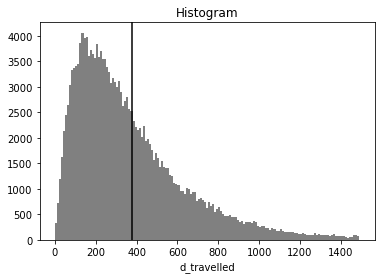

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
_, _, _ = d_travelled.plot.hist(ax=ax, bins=np.arange(0.,1.5e3,10.), color='0.5')
ax.axvline(x=d_travelled.mean(),color='k')

---

In [22]:
rb = np.arange(0.,400.,10.)
rc = (rb[:-1]+rb[1:])*.5

In [23]:
ds['r'] = ds.r.where(~np.isnan(ds.U_0_inertial*ds.U_0_low), drop=False)
#mask = xr.where(np.isnan(ds.LON_0_inertial*ds.LON_0_low), 0, 1)
#ds.r = ds.r*mask

In [24]:
N_r = edr.bin1d(ds.r, ds.r, rb, False, bin_dim='rb', name='N_r')
N_r = N_r.sum('index')

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask/array/blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


In [25]:
latb = np.arange(-70.,70.,1.)
latc = (latb[:-1]+latb[1:])*.5
lonb = np.arange(-180.,180.,1.)
lonc = (lonb[:-1]+lonb[1:])*.5

In [26]:
ll = edr.bin2d(ds.r, ds.LON_0, lonb, ds.LAT_0, latb, False, bin_dim1='lonb', bin_dim2='latb', name='Ncount')
ll = ll.sum('index')

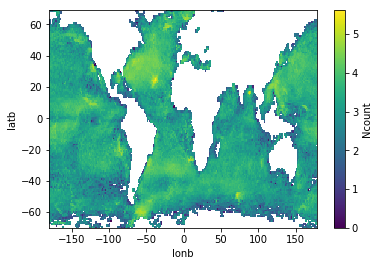

In [27]:
np.log10(ll).plot(x='lonb', y='latb')

---

## plot selected trajectories

In [28]:
lds = ds.isel(index=slice(0,2000)).persist()

In [29]:
rmean = lds.r.mean('TIME').persist()
#U02_inertial_mean = (lds.U_0_inertial**2).mean('TIME').persist()
U_inertial = np.abs(lds.U_0_inertial).mean('TIME').persist()

In [30]:
#lds = lds.where( (rmean<105) & (rmean>95) , drop=True)
lds = lds.where( U_inertial>.1 , drop=True)
lds

<xarray.Dataset>
Dimensions:       (TIME: 721, index: 104)
Coordinates:
  * TIME          (TIME) timedelta64[ns] 00:00:00 01:00:00 ... 30 days 00:00:00
Dimensions without coordinates: index
Data variables:
    LAT_0         (index, TIME) float64 dask.array<shape=(104, 721), chunksize=(29, 721)>
    LON_0         (index, TIME) float64 dask.array<shape=(104, 721), chunksize=(29, 721)>
    U_0           (index, TIME) float64 dask.array<shape=(104, 721), chunksize=(29, 721)>
    V_0           (index, TIME) float64 dask.array<shape=(104, 721), chunksize=(29, 721)>
    v0_0          (index, TIME) float64 dask.array<shape=(104, 721), chunksize=(29, 721)>
    v1_0          (index, TIME) float64 dask.array<shape=(104, 721), chunksize=(29, 721)>
    v2_0          (index, TIME) float64 dask.array<shape=(104, 721), chunksize=(29, 721)>
    LAT_1         (index, TIME) float64 dask.array<shape=(104, 721), chunksize=(29, 721)>
    LON_1         (index, TIME) float64 dask.array<shape=(104, 721), chunk

In [31]:
#del lds

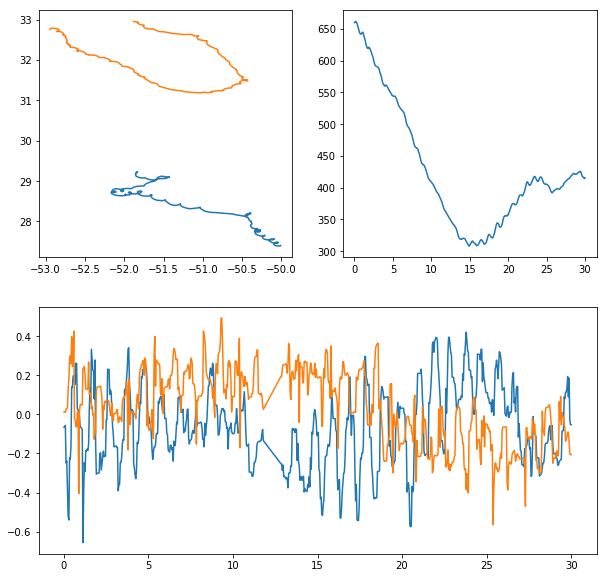

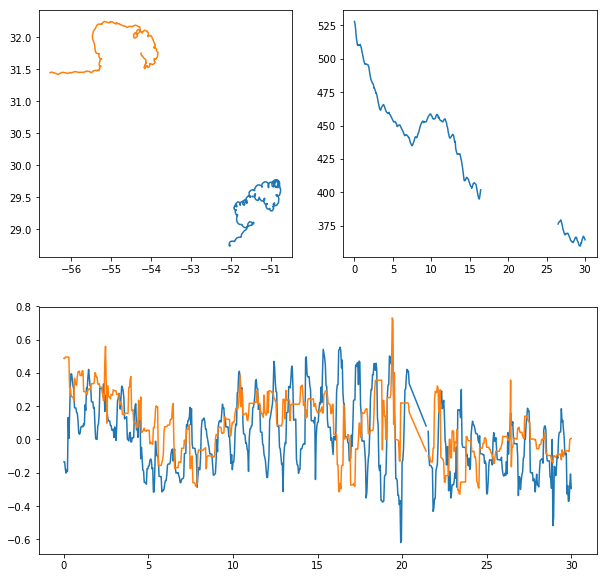

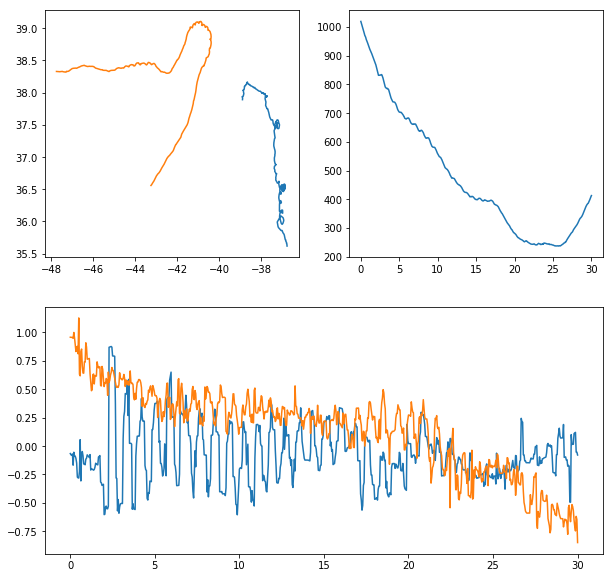

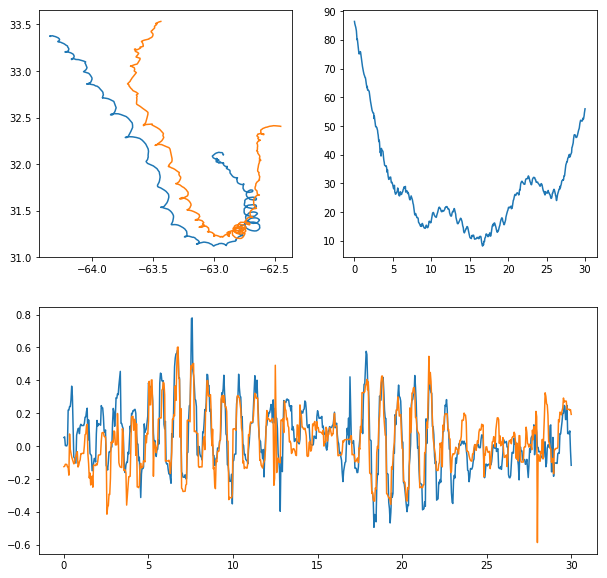

In [32]:
def plot_trajectories(ds):
    t = ds.TIME/np.timedelta64(1, 'D')
    for i in ds.index:
        lds = ds.sel(index=i)
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(221)
        ax.plot(lds.LON_0, lds.LAT_0, label='0')
        ax.plot(lds.LON_1, lds.LAT_1, label='1')
        ax = fig.add_subplot(212)
        ax.plot(t,lds.U_0, label='0')
        ax.plot(t,lds.U_1, label='1')
        ax = fig.add_subplot(222)
        ax.plot(t,lds.r,label='r')
        #print(lds.lon_1.values)
        
plot_trajectories(lds.isel(index=slice(0,4)))

---
## computations of decorrelation length scales for velocity

In [33]:
def get_UV_prod(N_r, band=''):
    ods = N_r.to_dataset()
    if band != '':
        suff = '_'+band
    else:
        suff = band
    #
    for u0 in ['U', 'V']:
        for u1 in ['U', 'V']:
            ods[u0+'0'+u1+'1'+suff] = (edr.bin1d(ds[u0+'_0'+suff]*ds[u1+'_1'+suff], ds.r, rb, 
                                   True, bin_dim='rb')
                                  .sum('index')/ods.N_r)
    for i in ['0','1']:
        for u in ['U','V']:
            ods[u+i+u+i+suff] = (edr.bin1d(ds[u+'_'+i+suff]*ds[u+'_'+i+suff], ds.r, rb, 
                                   True, bin_dim='rb')
                            .sum('index')/ods.N_r)
    return ods

In [34]:
ds_inst = get_UV_prod(N_r)
ds_low = get_UV_prod(N_r, 'low')
ds_inertial = get_UV_prod(N_r, 'inertial')
ods = xr.merge([ds_inst, ds_low, ds_inertial]).persist()

In [35]:
ods

<xarray.Dataset>
Dimensions:        (rb: 39)
Coordinates:
  * rb             (rb) float64 5.0 15.0 25.0 35.0 ... 355.0 365.0 375.0 385.0
Data variables:
    N_r            (rb) float64 dask.array<shape=(39,), chunksize=(39,)>
    U0U1           (rb) float64 dask.array<shape=(39,), chunksize=(39,)>
    U0V1           (rb) float64 dask.array<shape=(39,), chunksize=(39,)>
    V0U1           (rb) float64 dask.array<shape=(39,), chunksize=(39,)>
    V0V1           (rb) float64 dask.array<shape=(39,), chunksize=(39,)>
    U0U0           (rb) float64 dask.array<shape=(39,), chunksize=(39,)>
    V0V0           (rb) float64 dask.array<shape=(39,), chunksize=(39,)>
    U1U1           (rb) float64 dask.array<shape=(39,), chunksize=(39,)>
    V1V1           (rb) float64 dask.array<shape=(39,), chunksize=(39,)>
    U0U1_low       (rb) float64 dask.array<shape=(39,), chunksize=(39,)>
    U0V1_low       (rb) float64 dask.array<shape=(39,), chunksize=(39,)>
    V0U1_low       (rb) float64 dask.array<s

In [36]:
def plot_band(band):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(131)

    U0U0, V0V0 = ods['U0U0'+band], ods['V0V0'+band]
    U1U1, V1V1 = ods['U1U1'+band], ods['V1V1'+band]
    U0U1, V0V1 = ods['U0U1'+band], ods['V0V1'+band]

    (U0U1/np.sqrt(U0U0*U1U1)).plot(ax=ax, label='U0U1 normalized')
    (V0V1/np.sqrt(V0V0*V1V1)).plot(ax=ax, label='V0V1 normalized')
    ax.legend()
    ax.set_ylim(0.,1.)

    ax = fig.add_subplot(132)
    np.sqrt(U0U0).plot(ax=ax, label='U0U0')
    np.sqrt(V0V0).plot(ax=ax, label='V0V0')
    np.sqrt(U1U1).plot(ax=ax, color='C0', ls='--')
    np.sqrt(V1V1).plot(ax=ax, color='C1', ls='--')
    ax.legend()
    ax = fig.add_subplot(133)
    ods.N_r.plot(ax=ax)

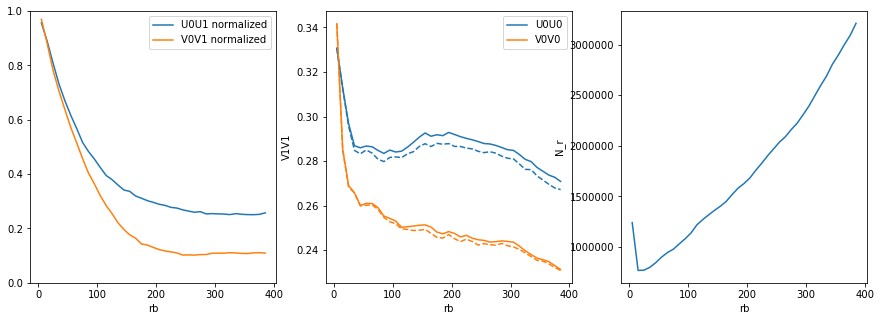

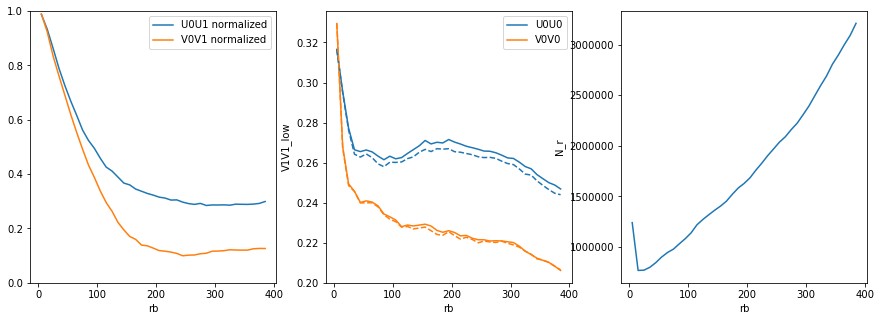

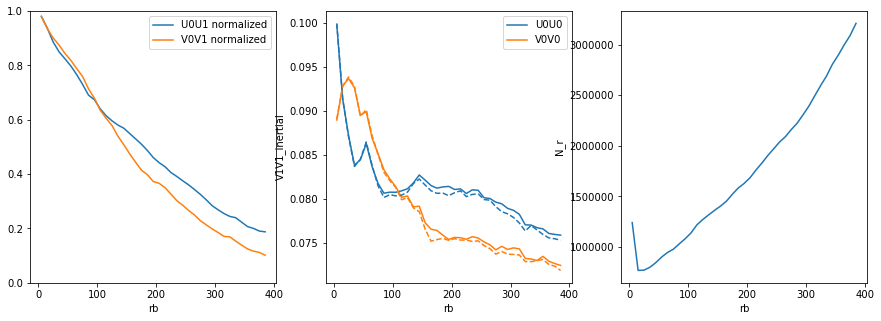

In [37]:
for band in ['','_low','_inertial']:
    plot_band(band)

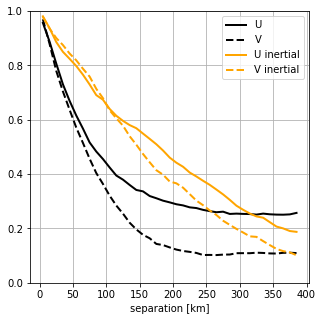

In [40]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

band=''
U0U0, V0V0 = ods['U0U0'+band], ods['V0V0'+band]
U1U1, V1V1 = ods['U1U1'+band], ods['V1V1'+band]
U0U1, V0V1 = ods['U0U1'+band], ods['V0V1'+band]

(U0U1/np.sqrt(U0U0*U1U1)).plot(ax=ax, ls='-', color='k', lw=2,label='U')
(V0V1/np.sqrt(V0V0*V1V1)).plot(ax=ax, ls='--', color='k', lw=2,label='V')

band='_inertial'
U0U0, V0V0 = ods['U0U0'+band], ods['V0V0'+band]
U1U1, V1V1 = ods['U1U1'+band], ods['V1V1'+band]
U0U1, V0V1 = ods['U0U1'+band], ods['V0V1'+band]

(U0U1/np.sqrt(U0U0*U1U1)).plot(ax=ax, ls='-', color='orange', lw=2,label='U inertial')
(V0V1/np.sqrt(V0V0*V1V1)).plot(ax=ax, ls='--', color='orange', lw=2,label='V inertial')

ax.legend()
ax.set_ylim(0.,1.)
ax.set_xlabel('separation [km]')
ax.grid()


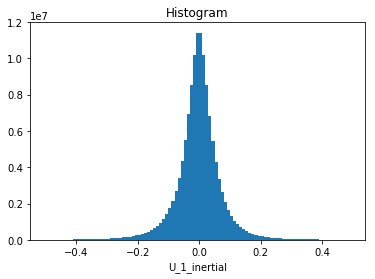

In [36]:
_ = ds['U_1_inertial'].plot.hist(bins=np.arange(-.5,.5,.01))

---

In [15]:
client.restart()

Worker tcp://10.135.36.30:37400 restart in Job 5186153. This can be due to memory issue.
Worker tcp://10.135.36.31:37448 restart in Job 5186157. This can be due to memory issue.
Worker tcp://10.135.36.30:34829 restart in Job 5186152. This can be due to memory issue.
Worker tcp://10.135.36.30:37789 restart in Job 5186151. This can be due to memory issue.
Worker tcp://10.135.36.30:38801 restart in Job 5186155. This can be due to memory issue.
Worker tcp://10.135.36.29:35096 restart in Job 5186148. This can be due to memory issue.
Worker tcp://10.135.36.30:33785 restart in Job 5186154. This can be due to memory issue.
Worker tcp://10.135.36.29:44859 restart in Job 5186150. This can be due to memory issue.
Worker tcp://10.135.36.31:37280 restart in Job 5186156. This can be due to memory issue.
Worker tcp://10.135.36.29:43596 restart in Job 5186149. This can be due to memory issue.


Client Scheduler: tcp://10.135.39.56:37775 Dashboard: http://10.135.39.56:8787/status,Cluster Workers: 10 Cores: 10 Memory: 200.00 GB


In [ ]:
cluster.close()